# Figure 3

In [1]:
import numpy as np
import os
import matplotlib.pyplot as plt      
import matplotlib
import scipy.stats as sp
import pandas as pd
from scipy.special import logsumexp

import replay_structure.metadata as meta
import replay_structure.read_write as read_write
import replay_structure.metadata as meta

import importlib

#### Model comparison results

In [2]:
ratday_data = dict()
model_comparison_results = dict()
deviance_explained_results = dict()
for session in meta.Session_List:
    ratday_data[session.rat, session.day] = read_write.load_ratday_data(session)
    model_comparison_results[session.rat, session.day] = read_write.load_model_comparison_results(
        session, meta.Ripple_Data.default_time_window_ms, meta.Ripple_Data.name, meta.Ripple_Data.default_likelihood_function)
    deviance_explained_results[session.rat, session.day] = read_write.load_deviance_explained_results(
        session, meta.Ripple_Data.default_time_window_ms, meta.Ripple_Data.name, meta.Ripple_Data.default_likelihood_function)

loading  /Users/emmakrause/Documents/PhD/Lab/replay_structure/data_final/ratday/rat1day1_4cm.obj
loading  /Users/emmakrause/Documents/PhD/Lab/replay_structure/results_final/ripples/rat1day1_4cm_3ms_poisson_model_comparison.obj
loading  /Users/emmakrause/Documents/PhD/Lab/replay_structure/results_final/ripples/rat1day1_4cm_3ms_poisson_deviance_explained.obj
loading  /Users/emmakrause/Documents/PhD/Lab/replay_structure/data_final/ratday/rat1day2_4cm.obj
loading  /Users/emmakrause/Documents/PhD/Lab/replay_structure/results_final/ripples/rat1day2_4cm_3ms_poisson_model_comparison.obj
loading  /Users/emmakrause/Documents/PhD/Lab/replay_structure/results_final/ripples/rat1day2_4cm_3ms_poisson_deviance_explained.obj
loading  /Users/emmakrause/Documents/PhD/Lab/replay_structure/data_final/ratday/rat2day1_4cm.obj
loading  /Users/emmakrause/Documents/PhD/Lab/replay_structure/results_final/ripples/rat2day1_4cm_3ms_poisson_model_comparison.obj
loading  /Users/emmakrause/Documents/PhD/Lab/replay_str

In [3]:
# calculate mean/sd p(M|X) across sessions
p_models = np.zeros((meta.N_SESSIONS, meta.N_MODELS))
for i, session in enumerate(meta.Session_List):
    p_models[i] = model_comparison_results[session.rat,session.day].random_effects_results["p_models"]
    
p_models_mean = np.mean(p_models, axis=0)
p_models_sd = np.std(p_models, axis=0)

# print p(M|X) mean and sd
for i, model in enumerate(meta.MODELS_AS_STR):
    print(f"{model} model: {np.round(p_models_mean[i]*100,1)}% +/- {np.round(p_models_sd[i]*100,1)}%")

# print p(M|X) grouped by trajectory/non-trajectory models
print("\n")
sum_trajectory = np.sum(p_models[:,:2], axis=1)*100
sum_nontrajectory = np.sum(p_models[:,2:], axis=1)*100
print(f"trajectory models: {np.round(np.mean(sum_trajectory), 1)}% +/- {np.round(np.std(sum_trajectory),1)}")
print(f"non-trajecotry models: {np.round(np.mean(sum_nontrajectory), 1)}% +/- {np.round(np.std(sum_nontrajectory),1)}")

diffusion model: 4.8% +/- 0.9%
momentum model: 84.9% +/- 2.9%
stationary model: 4.5% +/- 0.7%
stationary_gaussian model: 3.0% +/- 0.7%
random model: 2.8% +/- 0.8%


trajectory models: 89.7% +/- 2.0
non-trajecotry models: 10.3% +/- 2.0


In [4]:
print(f"exceedance probabilities for models {meta.MODELS_AS_STR}")
for i, session in enumerate(meta.Session_List):
    print(f"{session}: {model_comparison_results[session.rat,session.day].random_effects_results['p_exceedance']}")

exceedance probabilities for models ['diffusion', 'momentum', 'stationary', 'stationary_gaussian', 'random']
rat1day1: [0. 1. 0. 0. 0.]
rat1day2: [0. 1. 0. 0. 0.]
rat2day1: [0. 1. 0. 0. 0.]
rat2day2: [0. 1. 0. 0. 0.]
rat3day1: [0. 1. 0. 0. 0.]
rat3day2: [0. 1. 0. 0. 0.]
rat4day1: [0. 1. 0. 0. 0.]
rat4day2: [0. 1. 0. 0. 0.]


#### Comparison to previous classification results

In [19]:
percent_significant_ripples = np.zeros(meta.N_SESSIONS)
percent_trajectory_model = np.zeros(meta.N_SESSIONS)
for i, session in enumerate(meta.Session_List):
    percent_significant_ripples[i] = len(ratday_data[session.rat, session.day].data['significant_ripples'])/ratday_data[session.rat, session.day].data['n_ripples']
    percent_trajectory_model[i] = model_comparison_results[session.rat,session.day].random_effects_results["p_models"][[0,1]].sum()
    
percent_significant_ripples_mean = np.mean(percent_significant_ripples, axis=0)
percent_significant_ripples_sd = np.std(percent_significant_ripples, axis=0)
percent_trajectory_model_mean = np.mean(percent_trajectory_model, axis=0)
percent_trajectory_model_sd = np.std(percent_trajectory_model, axis=0)

print(f"previously classified: {np.round(np.mean(percent_significant_ripples)*100,1)}% +/- {np.round(np.std(percent_significant_ripples)*100,1)}")

previously classified: 22.8% +/- 8.4


#### Model recovery results

In [6]:
model_recovery_mc_results = dict()
model_recovery_random_effects = np.zeros((5, 5))
model_recovery_best_fit = np.zeros((5,5))
for i, session in enumerate(meta.Simulated_Session_List):
    model_recovery_mc_results[str(session.model.name)] = read_write.load_model_comparison_results(
        session, meta.Poisson_Simulated_Ripple_Data.default_time_window_ms, meta.Poisson_Simulated_Ripple_Data.name, meta.Poisson_Simulated_Ripple_Data.default_likelihood_function)
    model_recovery_random_effects[i] = model_recovery_mc_results[str(session.model.name)].random_effects_results["p_models"]
    model_recovery_best_fit[i] = model_recovery_mc_results[str(session.model.name)].max_ll_counts / model_recovery_mc_results[str(session.model.name)].max_ll_counts.sum()

loading  /Users/emmakrause/Documents/PhD/Lab/replay_structure/results_final/poisson_simulated_ripples/diffusion_4cm_3ms_poisson_model_comparison.obj
loading  /Users/emmakrause/Documents/PhD/Lab/replay_structure/results_final/poisson_simulated_ripples/momentum_4cm_3ms_poisson_model_comparison.obj
loading  /Users/emmakrause/Documents/PhD/Lab/replay_structure/results_final/poisson_simulated_ripples/stationary_4cm_3ms_poisson_model_comparison.obj
loading  /Users/emmakrause/Documents/PhD/Lab/replay_structure/results_final/poisson_simulated_ripples/stationary_gaussian_4cm_3ms_poisson_model_comparison.obj
loading  /Users/emmakrause/Documents/PhD/Lab/replay_structure/results_final/poisson_simulated_ripples/random_4cm_3ms_poisson_model_comparison.obj


In [7]:
# F1 score trajectory vs non_trajectory
cm_trajectory = np.zeros((2,2))
cm_trajectory[0,0] = model_recovery_random_effects[:2,:2].sum()
cm_trajectory[0,1] = model_recovery_random_effects[:2,2:].sum()
cm_trajectory[1,0] = model_recovery_random_effects[2:,:2].sum()
cm_trajectory[1,1] = model_recovery_random_effects[2:,2:].sum()

cm_trajectory = (cm_trajectory.T/cm_trajectory.sum(axis=1)).T

print("Trajectory vs non_trajectory")
trajectory_accuracy = (cm_trajectory[0,0] + cm_trajectory[1,1])/2
trajectory_precision = cm_trajectory[0,0]/(cm_trajectory[0,0] + cm_trajectory[1,0])
trajectory_recall = cm_trajectory[0,0]/(cm_trajectory[0,0] + cm_trajectory[0,1])
trajectory_fscore = (2*trajectory_precision*trajectory_recall)/(trajectory_precision + trajectory_recall)
print("F-score: ", trajectory_fscore.round(2))

Trajectory vs non_trajectory
F-score:  0.94


In [8]:
print("diffusion misclassified as momentum: ", (model_recovery_random_effects[0,1]*100).round(1), "%")
print("momentum misclassified as diffusion: ", (model_recovery_random_effects[1,0]*100).round(1), "%")

diffusion misclassified as momentum:  6.0 %
momentum misclassified as diffusion:  25.5 %


#### Deviance explained results

In [9]:
all_deviance_explained = deviance_explained_results[1,1].results
for session in meta.Session_List[1:]:
    all_deviance_explained = all_deviance_explained.append(deviance_explained_results[session.rat,session.day].results)
    
all_deviance_explained_with_popburst = all_deviance_explained[~np.any(np.isnan(all_deviance_explained), axis=1)]
total_SWRs_with_popburst = len(all_deviance_explained_with_popburst)

deviance_explained_x_best_fit = np.sort(all_deviance_explained_with_popburst.max(axis=1))
deviance_explained_x_random = np.sort(all_deviance_explained_with_popburst['random'])
deviance_explained_y = np.arange(total_SWRs_with_popburst)/total_SWRs_with_popburst

print(f"Deviance explained best fit: {deviance_explained_x_best_fit.mean().round(3)} +/- {deviance_explained_x_best_fit.std().round(3)}")
print(f"Deviance explained random: {deviance_explained_x_random.mean().round(3)} +/- {deviance_explained_x_random.std().round(3)}")
print(sp.ttest_rel(deviance_explained_x_best_fit, deviance_explained_x_random), f"deg of freedom={total_SWRs_with_popburst}")

Deviance explained best fit: 0.234 +/- 0.07
Deviance explained random: 0.099 +/- 0.05
Ttest_relResult(statistic=339.87712364258266, pvalue=0.0) deg of freedom=2883


#### Make figure

In [10]:
def truncate_colormap(cmap, minval=0.0, maxval=1.0, n=100):
    # From https://stackoverflow.com/a/18926541
    new_cmap = matplotlib.colors.LinearSegmentedColormap.from_list(
        'trunc({n},{a:.2f},{b:.2f})'.format(n=cmap.name, a=minval, b=maxval),
        cmap(np.linspace(minval, maxval, n)))
    return new_cmap

cmap_use = truncate_colormap(matplotlib.cm.magma, minval=.1, maxval=1)

In [11]:
axis_label_fontsize = 6
letter_ticks_fontsize = 6
number_ticks_fontsize = 5
legend_fontsize=5

In [12]:
model_names_dict = {'diffusion': 'Diffusion', 
               'momentum': 'Momentum', 
               'stationary': 'Stationary', 
               'stationary_gaussian': 'Gaussian', 
               'random': 'Random'}
model_names = [model_names_dict[model] for model in meta.MODELS_AS_STR]

temporal_model_colors = {True: '#9e1f63', False: '#fbb040'}
model_colors = [temporal_model_colors[model.trajectory] for model in meta.MODELS]
previous_classification_colors = {'classified': 'seagreen', 'not_classified': 'darkgray'}

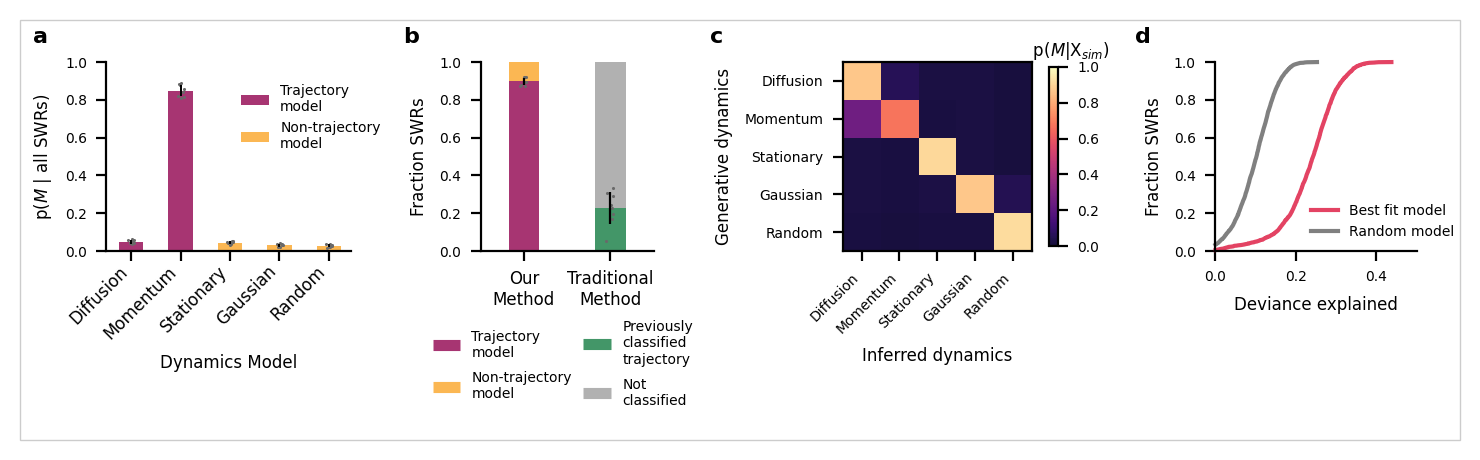

In [13]:
figure_width = 7.2
figure_height = 2.1

margin = 0.06
header_height = 0.1
footer_height = 0.45

w_spacing = 0.09

# define plot dimensions (relative to a "1x1" plot for a marginal)
panel1_width = .17
panel2_width = .12
panel3_width = .17#.2
panel4_width = .14

panel_height = 1 - header_height - footer_height

panel1_left = margin
panel2_left = margin + panel1_width + w_spacing
panel3_left = margin + panel1_width + panel2_width + 2*w_spacing + .04
panel4_left = margin + panel1_width + panel2_width + panel3_width + 3*w_spacing + .04

panel_bottom = footer_height

fig = plt.figure(
    figsize=(figure_width, figure_height), dpi=200, facecolor="w", edgecolor="k"
)
ax = dict()

# model comparison summary

x_axis = np.arange(meta.N_MODELS)+.5

i = 0
ax[i] = fig.add_axes([panel1_left, panel_bottom, panel1_width, panel_height])
ax[i].spines["right"].set_visible(False)
ax[i].spines["top"].set_visible(False)
ax[i].set_xticks(x_axis)
ax[i].set_xticklabels(model_names, rotation=45, ha='right', fontsize=letter_ticks_fontsize)
ax[i].set_xlim([0,meta.N_MODELS-.05])
ax[i].tick_params(axis='y', labelsize=number_ticks_fontsize)
ax[i].set_ylabel("p($M$ | all SWRs)", fontsize=axis_label_fontsize)
ax[i].set_xlabel("Dynamics Model", fontsize=axis_label_fontsize)
ax[i].set_ylim([0,1])
ax[i].tick_params(axis='x', pad=.7)

custom_patches = [matplotlib.patches.Patch(facecolor=temporal_model_colors[True], alpha=.9,label='Trajectory\nmodel'),
               matplotlib.patches.Patch(facecolor=temporal_model_colors[False], alpha=.9,label='Non-trajectory\nmodel'),
              ]
ax[i].legend(
    handles=custom_patches, 
    fontsize=legend_fontsize,
    bbox_to_anchor=(.5, .95, 0, 0),
    ncol=1,
    frameon=False)

ax[i].bar(x_axis, p_models_mean, yerr=p_models_sd,
        width=.5, color=model_colors, alpha=.9, error_kw=dict(lw=.7, zorder=101))
for s in range(meta.N_SESSIONS):
    ax[i].scatter(x_axis+(np.random.rand()-.5)/8, p_models[s], s=5, color='dimgray', zorder=100, marker='.', linewidths=0)

# trajectory v. non-trajectory

x_axis = np.arange(2) + .5

i = 1
ax[i] = fig.add_axes([panel2_left, panel_bottom, panel2_width, panel_height])
ax[i].spines["right"].set_visible(False)
ax[i].spines["top"].set_visible(False)
ax[i].tick_params(axis='y', labelsize=number_ticks_fontsize)
ax[i].set_xticks(x_axis)
ax[i].set_xticklabels(["Our\nMethod", "Traditional\nMethod"], ha='center', fontsize=letter_ticks_fontsize)
ax[i].set_xlim([0,2])
ax[i].set_ylabel("Fraction SWRs", fontsize=axis_label_fontsize)
ax[i].set_ylim([0,1])

bar_width = .35
alpha=.9

ax[i].bar(x_axis, [percent_trajectory_model_mean, percent_significant_ripples_mean], yerr=[percent_trajectory_model_sd, percent_significant_ripples_sd], 
          width=bar_width, color=[temporal_model_colors[True], previous_classification_colors['classified']], alpha=alpha, error_kw=dict(lw=.8, zorder=101))
ax[i].bar(x_axis, [1-percent_trajectory_model_mean, 1-percent_significant_ripples_mean], bottom=[percent_trajectory_model_mean, percent_significant_ripples_mean], 
          width=bar_width, color=[temporal_model_colors[False], previous_classification_colors['not_classified']], alpha=alpha)
for s in range(meta.N_SESSIONS):
    ax[i].scatter(x_axis+(np.random.rand()-.5)/8, [percent_trajectory_model[s], percent_significant_ripples[s]], s=5, color='dimgray', zorder=100, marker='.', linewidths=0)

custom_lines_1 = [matplotlib.lines.Line2D([0], [0], color=temporal_model_colors[True], lw=4, linestyle='--', alpha=alpha),
               matplotlib.lines.Line2D([0], [0], color=temporal_model_colors[False], lw=4, linestyle='--', alpha=alpha)]

custom_lines_2 = [matplotlib.lines.Line2D([0], [0], color=previous_classification_colors['classified'], lw=4, linestyle='--', alpha=alpha),
                matplotlib.lines.Line2D([0], [0], color=previous_classification_colors['not_classified'], lw=4, linestyle='--', alpha=alpha)]


leg_1 = ax[i].legend(
    handles=custom_lines_2, 
    labels=['Previously\nclassified\ntrajectory', 'Not\nclassified'],
    bbox_to_anchor=(1.3, -.3, 0, 0), fontsize=legend_fontsize,
    ncol=1,
    frameon=False,
    labelspacing=.8)
leg_2 = ax[i].legend(
    handles=custom_lines_1, 
    labels=['Trajectory\nmodel', 'Non-trajectory\nmodel'],
    bbox_to_anchor=(.6, -.35, 0, 0), fontsize=legend_fontsize,
    ncol=1,
    frameon=False,
    labelspacing=.8)
ax[i].add_artist(leg_1)

# confusion matrix from simulated data

xy_axis = np.arange(meta.N_MODELS)

i = 2
ax[i] = fig.add_axes([panel3_left, panel_bottom, panel3_width, panel_height])
ax[i].set_xticks(xy_axis)
ax[i].set_xticklabels(model_names, rotation=45, ha='right', fontsize=letter_ticks_fontsize-1)
ax[i].set_yticks(xy_axis)
ax[i].set_yticklabels(model_names, rotation=0, ha='right', fontsize=letter_ticks_fontsize-1)
ax[i].set_ylabel("Generative dynamics", fontsize=axis_label_fontsize)
ax[i].set_xlabel("Inferred dynamics", fontsize=axis_label_fontsize)

im = ax[i].imshow(model_recovery_random_effects, vmin=0, vmax=1, cmap=cmap_use)
cbar = fig.colorbar(im, ax=ax[i], location='right', shrink=.95, pad=.07)
cbar.ax.set_title('       p($M$|X$_{sim}$)', fontsize=6, pad=4) 
cbar.ax.tick_params(labelsize=5)

# deviance explained

i = 3
ax[i] = fig.add_axes([panel4_left, panel_bottom, panel4_width, panel_height])
ax[i].spines["right"].set_visible(False)
ax[i].spines["top"].set_visible(False)
ax[i].tick_params(axis='both', labelsize=number_ticks_fontsize)
ax[i].set_ylabel("Fraction SWRs", fontsize=axis_label_fontsize)
ax[i].set_xlabel("Deviance explained", fontsize=axis_label_fontsize)
ax[i].set_ylim([0,1])
ax[i].set_xlim([0,.5])

ax[i].plot(deviance_explained_x_best_fit[deviance_explained_x_best_fit >0], 
           deviance_explained_y[deviance_explained_x_best_fit >0], 
           color='crimson', alpha=.8, label='Best fit model', clip_on=False)
ax[i].plot(deviance_explained_x_random[deviance_explained_x_random >0], 
           deviance_explained_y[deviance_explained_x_random >0], 
           color='gray', label='Random model', clip_on=False)
ax[i].legend(frameon=False, fontsize=legend_fontsize, loc=4, bbox_to_anchor=(1.25,0,0,0))

ax[0].text(-.3,1.1, "a", size=8, transform=ax[0].transAxes, fontweight='bold')
ax[1].text(-.45,1.1, "b", size=8, transform=ax[1].transAxes, fontweight='bold')
ax[2].text(-.7,1.1, "c", size=8, transform=ax[2].transAxes, fontweight='bold')
ax[3].text(-.4,1.1, "d", size=8, transform=ax[3].transAxes, fontweight='bold')

plt.savefig(os.path.join(meta.FIGURES_PATH, "Figure3.svg"), dpi=500, transparent=True)

rect = plt.Rectangle(
    # (lower-left corner), width, height
    (0, 0), 1, 1, fill=False, color="k", lw=.5, alpha=.2,
    zorder=1000, transform=fig.transFigure, figure=fig
)
fig.patches.extend([rect])

In [14]:
summary_df = read_write.load_descriptive_stats(meta.Ripple_Data.default_time_window_ms, meta.Ripple_Data.name, meta.Ripple_Data.default_likelihood_function)

In [15]:
SWRs_with_spiking_data = summary_df[~np.isnan(summary_df['current_location_x'])]
n_SWRs_with_spiking_data = len(SWRs_with_spiking_data)
print("# total SWRs: ", n_SWRs_with_spiking_data)

# total SWRs:  2956


In [16]:
SWRs_without_popburst = SWRs_with_spiking_data[np.isnan(SWRs_with_spiking_data['avg_fr'])]
SWRs_with_popburst = SWRs_with_spiking_data[~np.isnan(SWRs_with_spiking_data['avg_fr'])]
n_SWRs_without_popburst = len(SWRs_without_popburst)
n_SWRs_with_popburst = len(SWRs_with_popburst)
print("total # SWRs with popburst: ", n_SWRs_with_popburst)
print("# SWRs without population bursts: ", n_SWRs_without_popburst)
print("% SWRs without population bursts: ",np.round(n_SWRs_without_popburst/n_SWRs_with_spiking_data*100,1), "%")

total # SWRs with popburst:  2883
# SWRs without population bursts:  73
% SWRs without population bursts:  2.5 %


In [17]:
SWRs_previously_classified = SWRs_with_spiking_data[SWRs_with_spiking_data['map_classified_PF']==1]
nontrajectory_previously_classified = SWRs_previously_classified[SWRs_previously_classified['trajectory_model'] == 0]
n_previously_classified = (SWRs_with_spiking_data['map_classified_PF']==1).sum()
n_nontrajectory_previously_classified = len(nontrajectory_previously_classified)
print('# previously classified trajectories not classifed as trajectory model: ', np.round(n_nontrajectory_previously_classified/n_previously_classified*100,1), "%")
print('# previously classified trajectories not classifed as trajectory model: ', n_nontrajectory_previously_classified)
print('# previously classified trajectories that do not meat popburst criteria: ', (np.isnan(nontrajectory_previously_classified['avg_fr']).sum()))
nontrajectory_previously_classified['best_fit_model'].value_counts()

# previously classified trajectories not classifed as trajectory model:  8.3 %
# previously classified trajectories not classifed as trajectory model:  58
# previously classified trajectories that do not meat popburst criteria:  8


stationary             48
stationary_gaussian     2
Name: best_fit_model, dtype: int64

In [20]:
n_trajectory_SWRs = (SWRs_with_popburst['trajectory_model'] ==1).sum()
print("# SWRs classified as trajectory-model: ", n_trajectory_SWRs)
print("% of # SWRs with popburst classified as trajectory-model: ", np.round(n_trajectory_SWRs/n_SWRs_with_popburst*100, 1), "%")

# SWRs classified as trajectory-model:  2366
% of # SWRs with popburst classified as trajectory-model:  82.1 %
